In [11]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
root_name = 'Fig_3_4_Algorithm_Variations_Result'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'test_loss': get_checkpoint_loss,
                                                                                'n_nodes': get_checkpoint_n_stable_FPs},
                                                   results_subdir='Paper_Submission',
                                                   multi_job_comp=True)

In [ ]:
root_name = 'Fig_3_4_Algorithm_Variations_Result'
results_dir = '/scratch/oem214/learning-dynamics/results/Paper_Submission'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

In [6]:
### --- ASSIGN TIME POINTS TO STAGES --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=20,
                                                                          topological_window=1)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

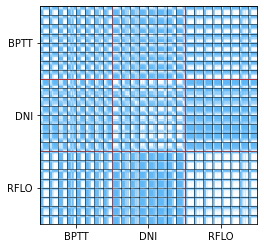

In [14]:
### --- GENERATE FULL CROSS-MATRIX --- ###

#Define basic constants for results arithmetic
algs = ['BPTT', 'DNI', 'RFLO']
n_algs = len(algs)
n_seeds = 8
n_checkpoints = 500
n_checkpoints_per_alg = n_seeds * n_checkpoints
n_total_checkpoints = n_algs * n_checkpoints_per_alg

#Extract distance matrix and symmetrize
M = result['aligned_graph_distances']
M = M + M.T

#Create figure and plot
fig = plt.figure()
#Colormap goes from white (smallest) to d_top blue (largest)
cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#3FA9F5'])
plt.imshow(M, cmap=cmap)

#Black lines to divide individual networks
for i_sim, i in enumerate(range(0, n_total_checkpoints, n_checkpoints)):
    plt.axhline(y=i, color='k', linewidth=0.5)
    plt.axvline(x=i, color='k', linewidth=0.5)
#Red lines to divide algorithms
plt.axhline(y=n_total_checkpoints*2/3, color='C3', linewidth=0.5)
plt.axvline(x=n_total_checkpoints*2/3, color='C3', linewidth=0.5)
plt.axhline(y=n_total_checkpoints/3, color='C3', linewidth=0.8)
plt.axvline(x=n_total_checkpoints/3, color='C3', linewidth=0.8)
#Identify algorithms as ticks
plt.xticks([n_checkpoints_per_alg/2, n_checkpoints_per_alg*3/2, n_checkpoints_per_alg*5/2], algs)
plt.yticks([n_checkpoints_per_alg/2, n_checkpoints_per_alg*3/2, n_checkpoints_per_alg*5/2], algs)

figs_path = 'figs'
fig_name = 'FigS3_Full_Cross_Matrix.pdf'
#fig.savefig(os.path.join(figs_path, fig_name), dpi=300, format='pdf')

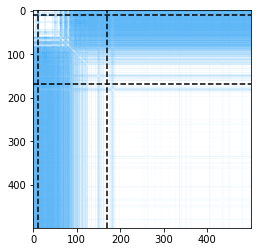

In [24]:
### --- ISOLATE INDIVIDUAL NETWORKS --- ###

#Define basic constants for results arithmetic
algs = ['BPTT', 'DNI', 'RFLO']
n_algs = len(algs)
n_seeds = 8
n_checkpoints = 500
n_checkpoints_per_alg = n_seeds * n_checkpoints
n_total_checkpoints = n_algs * n_checkpoints_per_alg

#Select networks (out of 24)
i_network = 16
j_network = 16

M = result['aligned_graph_distances']
M = M + M.T
submatrix = M[i_network*n_checkpoints:(i_network+1)*n_checkpoints,
              j_network*n_checkpoints:(j_network+1)*n_checkpoints]
fig = plt.figure()
#Colormap goes from white (smallest) to d_top blue (largest)
cmap = LinearSegmentedColormap.from_list('d_top', [('1'), '#3FA9F5'])
plt.imshow(submatrix, cmap=cmap)

#Add in lines for stage transitions
for t in dict_of_t_stage_transitions[signal_keys_ordered[i_network]]:
    if t is not None:
        plt.axvline(x=t, color='k', linestyle='--')
    else:
        pass
for t in dict_of_t_stage_transitions[signal_keys_ordered[j_network]]:
    if t is not None:
        plt.axhline(y=t, color='k', linestyle='--')
    else:
        pass

In [ ]:
### --- Cross stage analysis --- ###
base_string = 'analyze_three_algs_seed={}_learn_alg={}'
M = geo_result['PC2_distances']
M = M + M.T
algs = ['BPTT', 'DNI', 'RFLO']
cpj = 500 #checkpoints per job
n_jobs = 24
n_seeds = 8
n_stages = 4
stage_avg_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
stage_std_array = np.zeros((n_jobs, n_jobs, n_stages, n_stages))
for i_seed in range(n_seeds):
    for i_alg, alg_1 in enumerate(algs):
        i = i_alg * n_seeds + i_seed
        for j_seed in range(n_seeds):
            for j_alg, alg_2 in enumerate(algs):
                j = j_alg * n_seeds + j_seed
                
                i_job_key = base_string.format(i_seed, alg_1)
                j_job_key = base_string.format(j_seed, alg_2)                
                i_sa = dict_of_stage_assignments[i_job_key]
                j_sa = dict_of_stage_assignments[j_job_key]
                
                submatrix = M[i * cpj:(i+1) * cpj,
                              j * cpj:(j+1) * cpj]
             
                for i_stage_idx, i_stage in enumerate([0, 1, 2, 3]):
                    for j_stage_idx, j_stage in enumerate([0, 1, 2, 3]):
                        
                        i_idx = np.where(i_sa == i_stage + 1)[0]
                        j_idx = np.where(j_sa == j_stage + 1)[0]
                        
                        stage_matrix = submatrix[i_idx, :][:, j_idx]
                        if stage_matrix.size > 0:
                            mean = stage_matrix.mean()
                            std = stage_matrix.std()
                        else:
                            mean = np.nan
                            std = np.nan
                        stage_avg_array[i, j, i_stage_idx, j_stage_idx] = mean
                        stage_std_array[i, j, i_stage_idx, j_stage_idx] = std

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('owen', [('1'), '#3FA9F5'])
geo_cmap = LinearSegmentedColormap.from_list('geo', [('1'), '#1A8E48'])

In [ ]:
for i, i_alg in enumerate(['bptt', 'dni', 'rflo']):
    for j, j_alg in enumerate(['bptt', 'dni', 'rflo']):
        fig = plt.figure()
        color = '#3FA9F5'
        plt.imshow(np.nanmean(np.nanmean(stage_avg_array[i*8:(i+1)*8,j*8:(j+1)*8], 0), 0), cmap=geo_cmap, vmin=0, vmax=1)
        plt.axis('off')
        plt.colorbar()
        figs_path = '../../figs/frf_talk/'
        fig_name = '{}_{}_comp'.format(i_alg, j_alg)
        #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [ ]:
fig = plt.figure()
i_sim = 18
cpj = 500
plt.imshow(M[cpj*i_sim:cpj*(i_sim+1), cpj*i_sim:cpj*(i_sim+1)], cmap=cmap)
for t in dict_of_t_stage_transitions[signal_keys_ordered[i_sim]]:
    if t is not None:
        plt.axvline(x=t, color='k', linestyle='--')
        plt.axhline(y=t, color='k', linestyle='--')
    else:
        pass
plt.axis('off')

figs_path = '../../figs/frf_talk/'
fig_name = 'sim_{}_stage_cut'.format(i_sim)
#fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

fig = plt.figure()
plt.imshow(stage_avg_array[i_sim, i_sim], cmap=cmap, vmax=1)
#plt.colorbar()
plt.axis('off')
figs_path = '../../figs/frf_talk/'
fig_name = 'sim_{}_stage_avg'.format(i_sim)
#fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

<ipython-input-21-52058b7f2791>:10: RuntimeWarning: Mean of empty slice.
  d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean()
/ext3/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-21-52058b7f2791>:26: RuntimeWarning: Mean of empty slice.
  d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean()


(0.51, 2.49, -0.011454400822737621, 0.0036259475215530846)

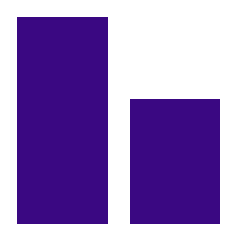

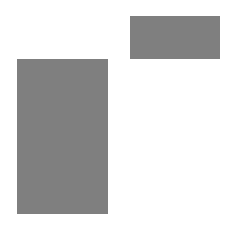

In [21]:
### --- FIGURE 2B CHANGES IN D_SYN AND L BY STAGE --- ###

## -- SYNAPTIC CHANGES -- ##

d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    d_syn = signals['rec_weight_distances']
    d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean() 
                        for i_stage in range(1, 5)]
    d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], d_syn_stage_means.mean(0), color='#3A0882')
plt.axis('off')
#fig.savefig('figs/fig2b_dsyn.pdf', dpi=300, format='pdf')

## -- LOSS CHANGES -- ##

d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    loss = signals['test_loss']
    d_loss = loss[1:] - loss[:-1]
    d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean() 
                         for i_stage in range(1, 5)]
    d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], -d_loss_stage_means.mean(0), color='#7F7F7F')
plt.axis('off')
#fig.savefig('figs/fig2b_dloss.pdf', dpi=300, format='pdf')

In [23]:
dict_of_t_stage_transitions

{'analyze_Fig_3_4_Algorithm_Variations_Result_seed=0_learn_alg=BPTT': [45,
  255,
  241],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=1_learn_alg=BPTT': [77,
  None,
  260],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=2_learn_alg=BPTT': [121,
  None,
  336],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=3_learn_alg=BPTT': [128,
  377,
  371],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=4_learn_alg=BPTT': [115,
  418,
  298],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=5_learn_alg=BPTT': [85,
  360,
  330],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=6_learn_alg=BPTT': [135,
  390,
  295],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=7_learn_alg=BPTT': [95,
  329,
  310],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=0_learn_alg=DNI': [1,
  None,
  415],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=1_learn_alg=DNI': [109,
  None,
  447],
 'analyze_Fig_3_4_Algorithm_Variations_Result_seed=2_learn_alg=DNI': [54,
  487,
  445],
 'ana